In [1]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_dir = '/content/drive/MyDrive/pneumonia FL dataset/train/'
test_dir = '/content/drive/MyDrive/pneumonia FL dataset/test/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

In [5]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

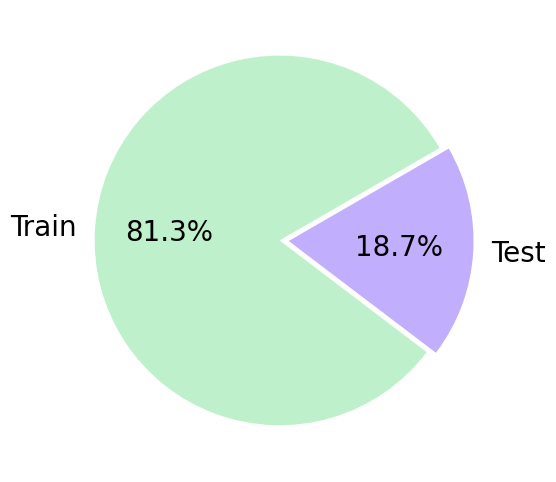

In [ ]:
plt.figure(figsize=(14,6))
colors = ['#BEF0CB', '#C1AEFC']
plt.rcParams.update({'font.size': 20})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

In [6]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

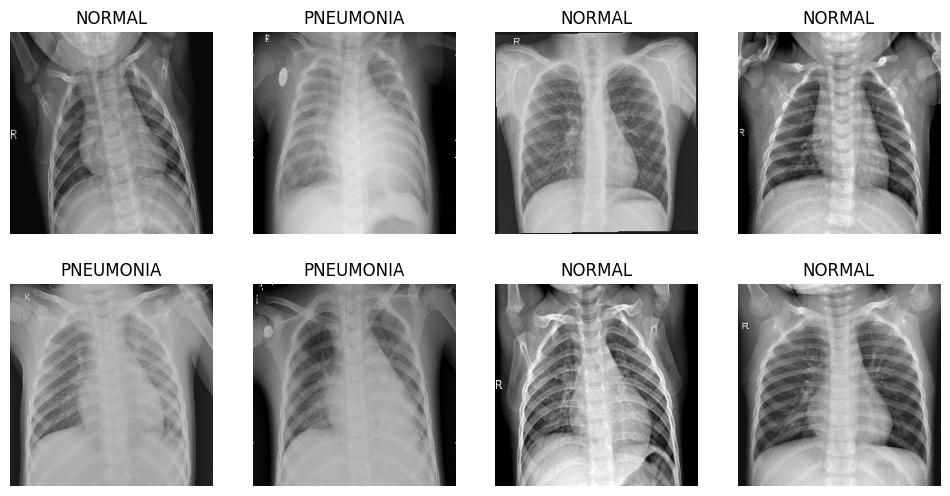

In [7]:
IMAGE_SIZE = 224

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 20})
plt.show()

In [8]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [9]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

58889256/58889256 [==============================] - 0s 0us/step


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 17926338 (68.38 MB)
Trainable params: 1029

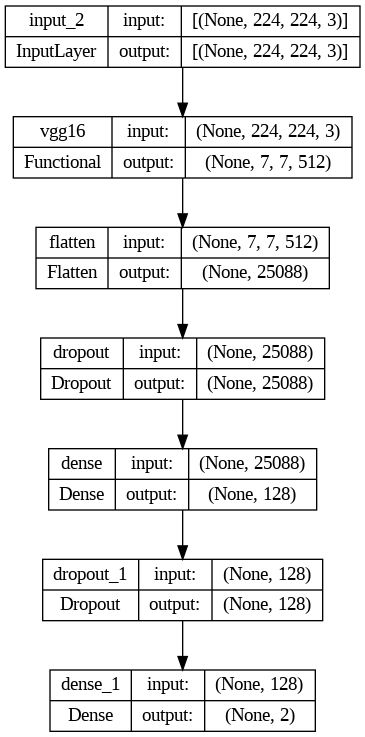

In [11]:
keras.utils.plot_model(model, show_shapes=True)

In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [13]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
234/234 [==============================] - 905s 4s/step - loss: 0.1612 - sparse_categorical_accuracy: 0.9348
Epoch 2/10
234/234 [==============================] - 74s 307ms/step - loss: 0.0905 - sparse_categorical_accuracy: 0.9648
Epoch 3/10
234/234 [==============================] - 70s 298ms/step - loss: 0.0685 - sparse_categorical_accuracy: 0.9741
Epoch 4/10
234/234 [==============================] - 70s 301ms/step - loss: 0.0627 - sparse_categorical_accuracy: 0.9753
Epoch 5/10
234/234 [==============================] - 72s 307ms/step - loss: 0.0549 - sparse_categorical_accuracy: 0.9798
Epoch 6/10
234/234 [==============================] - 70s 300ms/step - loss: 0.0391 - sparse_categorical_accuracy: 0.9854
Epoch 7/10
234/234 [==============================] - 69s 297ms/step - loss: 0.0296 - sparse_categorical_accuracy: 0.9876
Epoch 8/10
234/234 [==============================] - 69s 296ms/step - loss: 0.0326 - sparse_categorical_accuracy: 0.9878
Epoch 9/10
234/234 [======

# Federated Learning Based transfer Learning enabled VGG-16 Model

In [14]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the number of clients and the number of training rounds
NUM_CLIENTS = 4
NUM_ROUNDS = 3


# Define the clients and their data
clients = []
for i in range(NUM_CLIENTS):
    client_data = train_paths[i * (len(train_paths) // NUM_CLIENTS):(i + 1) * (len(train_paths) // NUM_CLIENTS)]
    client_labels = train_labels[i * (len(train_labels) // NUM_CLIENTS):(i + 1) * (len(train_labels) // NUM_CLIENTS)]
    clients.append((client_data, client_labels))

# Federated learning loop
for round_num in range(NUM_ROUNDS):

    # Select clients
    selected_client_indices = np.random.choice(len(clients), size=int(NUM_CLIENTS * 0.5), replace=False)
    selected_clients = [clients[i] for i in selected_client_indices]

    # Transmit the global model to the selected clients
    for client in selected_clients:
        client_model = tf.keras.models.clone_model(model)
        client_model.set_weights(model.get_weights())

        # Compile the client model
        client_model.compile(optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])

        steps_per_epoch = int(len(client[0]) / 20)


        client_model.fit(datagen(client[0],client[1], batch_size=batch_size, epochs=epochs),
                         epochs=5, steps_per_epoch=steps_per_epoch)

        # Train locally
        steps_per_epoch = int(len(client[0]) / 20)

        # Aggregate the model
        new_weights = []
        for layer_index in range(len(model.get_weights())):
            new_layer_weights = np.mean([client_model.get_weights()[layer_index], model.get_weights()[layer_index]], axis=0)
            new_weights.append(new_layer_weights)
        model.set_weights(new_weights)


batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

#     # Evaluate the global model
#     test_loss, test_acc = model.evaluate(test_paths, test_labels,)
#     print('Round {}: Test accuracy = {}'.format(round_num, test_acc))

# # Fine-tune the model
# model.fit(test_paths, test_labels, epochs=1, batch_size=32)

# Deploy the model
model.save('my_model.h5')

Epoch 1/5
58/58 [==============================] - 20s 299ms/step - loss: 0.0150 - sparse_categorical_accuracy: 0.9931
Epoch 2/5
58/58 [==============================] - 20s 288ms/step - loss: 0.0259 - sparse_categorical_accuracy: 0.9913
Epoch 3/5
58/58 [==============================] - 18s 317ms/step - loss: 0.0300 - sparse_categorical_accuracy: 0.9913
Epoch 4/5
58/58 [==============================] - 17s 298ms/step - loss: 0.0128 - sparse_categorical_accuracy: 0.9974
Epoch 5/5
58/58 [==============================] - 17s 297ms/step - loss: 0.0221 - sparse_categorical_accuracy: 0.9948
Epoch 1/5
58/58 [==============================] - 19s 287ms/step - loss: 0.0465 - sparse_categorical_accuracy: 0.9897
Epoch 2/5
58/58 [==============================] - 18s 308ms/step - loss: 0.0191 - sparse_categorical_accuracy: 0.9930
Epoch 3/5
58/58 [==============================] - 17s 296ms/step - loss: 0.0229 - sparse_categorical_accuracy: 0.9913
Epoch 4/5
58/58 [==============================]

  0%|          | 0/36 [00:00<?, ?it/s]

1/1 [==============================] - 7s 7s/step


  3%|▎         | 1/36 [00:15<08:46, 15.05s/it]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 2/36 [00:22<06:09, 10.85s/it]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 3/36 [00:30<05:14,  9.54s/it]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 4/36 [00:38<04:39,  8.73s/it]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 5/36 [00:48<04:45,  9.22s/it]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 6/36 [00:55<04:17,  8.59s/it]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 7/36 [01:03<03:57,  8.18s/it]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 8/36 [01:11<03:48,  8.15s/it]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 9/36 [01:18<03:34,  7.96s/it]

1/1 [==============================] - 0s 49ms/step


 28%|██▊       | 10/36 [01:26<03:26,  7.93s/it]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 11/36 [01:33<03:12,  7.71s/it]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 12/36 [01:41<03:01,  7.58s/it]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 13/36 [01:48<02:53,  7.56s/it]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 14/36 [01:56<02:50,  7.74s/it]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 15/36 [02:04<02:40,  7.66s/it]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 16/36 [02:11<02:31,  7.59s/it]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 17/36 [02:20<02:28,  7.80s/it]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 18/36 [02:27<02:18,  7.67s/it]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 19/36 [02:35<02:14,  7.92s/it]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 20/36 [02:43<02:05,  7.87s/it]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 21/36 [02:51<01:58,  7.91s/it]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 22/36 [02:58<01:48,  7.72s/it]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 23/36 [03:06<01:39,  7.67s/it]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 24/36 [03:13<01:30,  7.51s/it]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 25/36 [03:20<01:21,  7.45s/it]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 26/36 [03:28<01:14,  7.43s/it]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 27/36 [03:36<01:07,  7.51s/it]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 28/36 [03:43<00:59,  7.50s/it]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 29/36 [03:51<00:52,  7.50s/it]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 30/36 [03:58<00:44,  7.38s/it]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 31/36 [04:06<00:38,  7.67s/it]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 32/36 [04:14<00:30,  7.73s/it]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 33/36 [04:22<00:23,  7.78s/it]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 34/36 [04:29<00:15,  7.67s/it]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 35/36 [04:36<00:07,  7.55s/it]

1/1 [==============================] - 0s 30ms/step


100%|██████████| 36/36 [04:44<00:00,  7.63s/it]

1/1 [==============================] - 0s 143ms/step


37it [04:49,  7.81s/it]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      NORMAL       0.96      0.94      0.95       317
   PNEUMONIA       0.98      0.98      0.98       855

    accuracy                           0.97      1172
   macro avg       0.97      0.96      0.96      1172
weighted avg       0.97      0.97      0.97      1172



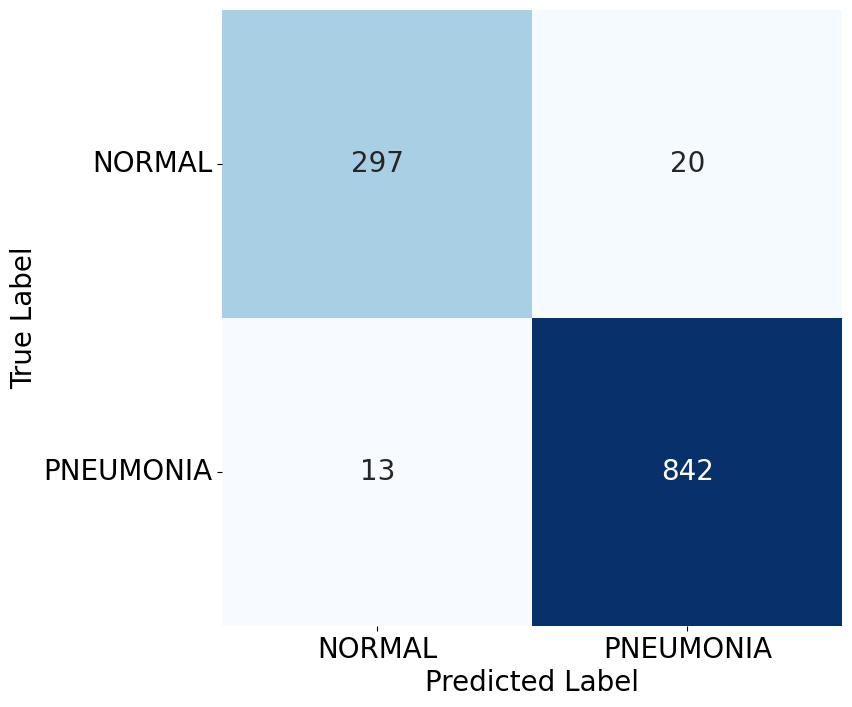

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np




cm = confusion_matrix(y_true, y_pred)

# Define the font size
font_size = 20

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, annot_kws={"fontsize": font_size}, cbar=False)
plt.xlabel("Predicted Label", fontsize=font_size)
plt.ylabel("True Label", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size, rotation=0)
plt.show()



# Improved Code of Transfer Learning Based VGG-16 Model

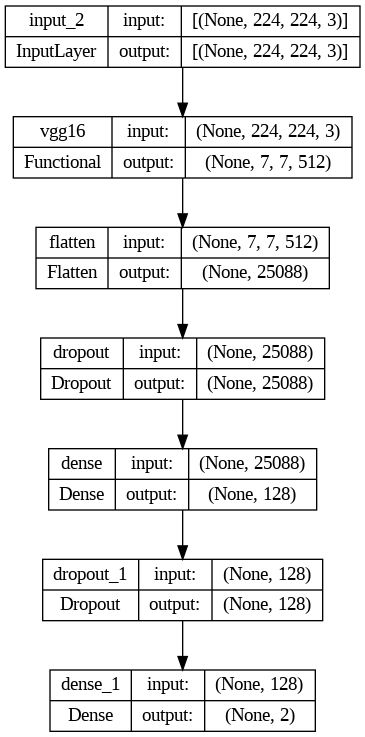

In [17]:
keras.utils.plot_model(model, show_shapes=True)

In [18]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [19]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
234/234 [==============================] - 72s 300ms/step - loss: 0.0213 - sparse_categorical_accuracy: 0.9927
Epoch 2/10
234/234 [==============================] - 73s 311ms/step - loss: 0.0279 - sparse_categorical_accuracy: 0.9936
Epoch 3/10
234/234 [==============================] - 71s 305ms/step - loss: 0.0112 - sparse_categorical_accuracy: 0.9953
Epoch 4/10
234/234 [==============================] - 71s 302ms/step - loss: 0.0186 - sparse_categorical_accuracy: 0.9946
Epoch 5/10
234/234 [==============================] - 72s 306ms/step - loss: 0.0187 - sparse_categorical_accuracy: 0.9940
Epoch 6/10
234/234 [==============================] - 72s 309ms/step - loss: 0.0153 - sparse_categorical_accuracy: 0.9946
Epoch 7/10
234/234 [==============================] - 70s 298ms/step - loss: 0.0082 - sparse_categorical_accuracy: 0.9968
Epoch 8/10
234/234 [==============================] - 69s 297ms/step - loss: 0.0187 - sparse_categorical_accuracy: 0.9942
Epoch 9/10
234/234 [====

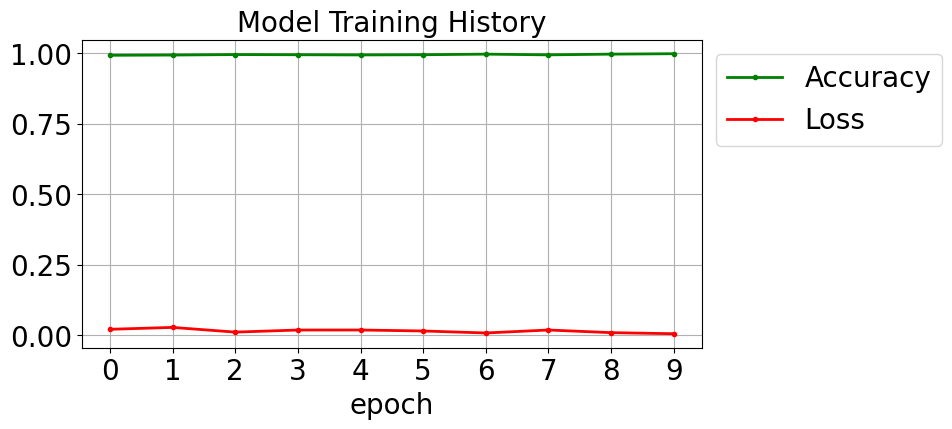

In [20]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History',fontsize =20)
plt.xlabel('epoch', fontsize =20)
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1), fontsize =20)
plt.show()

In [21]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/36 [00:00<?, ?it/s]

1/1 [==============================] - 0s 161ms/step


  3%|▎         | 1/36 [00:00<00:25,  1.38it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 2/36 [00:01<00:21,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 3/36 [00:01<00:20,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 4/36 [00:02<00:20,  1.57it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 5/36 [00:03<00:21,  1.47it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 6/36 [00:04<00:20,  1.43it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 7/36 [00:05<00:22,  1.26it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 8/36 [00:05<00:22,  1.23it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 9/36 [00:06<00:20,  1.33it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 10/36 [00:07<00:17,  1.46it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 11/36 [00:07<00:16,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 12/36 [00:08<00:14,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 13/36 [00:08<00:13,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 14/36 [00:09<00:13,  1.65it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 15/36 [00:09<00:12,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 16/36 [00:10<00:12,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 17/36 [00:11<00:11,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 18/36 [00:11<00:10,  1.66it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 19/36 [00:12<00:10,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 20/36 [00:12<00:09,  1.73it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 21/36 [00:13<00:08,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 22/36 [00:14<00:08,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 23/36 [00:14<00:07,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 24/36 [00:15<00:07,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 25/36 [00:15<00:06,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 26/36 [00:16<00:06,  1.49it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 27/36 [00:17<00:06,  1.30it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 28/36 [00:18<00:06,  1.28it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 29/36 [00:19<00:05,  1.34it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 30/36 [00:19<00:04,  1.43it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 31/36 [00:20<00:03,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 32/36 [00:20<00:02,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 33/36 [00:21<00:01,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 34/36 [00:22<00:01,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 35/36 [00:22<00:00,  1.62it/s]

1/1 [==============================] - 0s 36ms/step


100%|██████████| 36/36 [00:23<00:00,  1.63it/s]

1/1 [==============================] - 0s 160ms/step


37it [00:23,  1.55it/s]


In [22]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      NORMAL       0.97      0.93      0.95       317
   PNEUMONIA       0.97      0.99      0.98       855

    accuracy                           0.97      1172
   macro avg       0.97      0.96      0.96      1172
weighted avg       0.97      0.97      0.97      1172



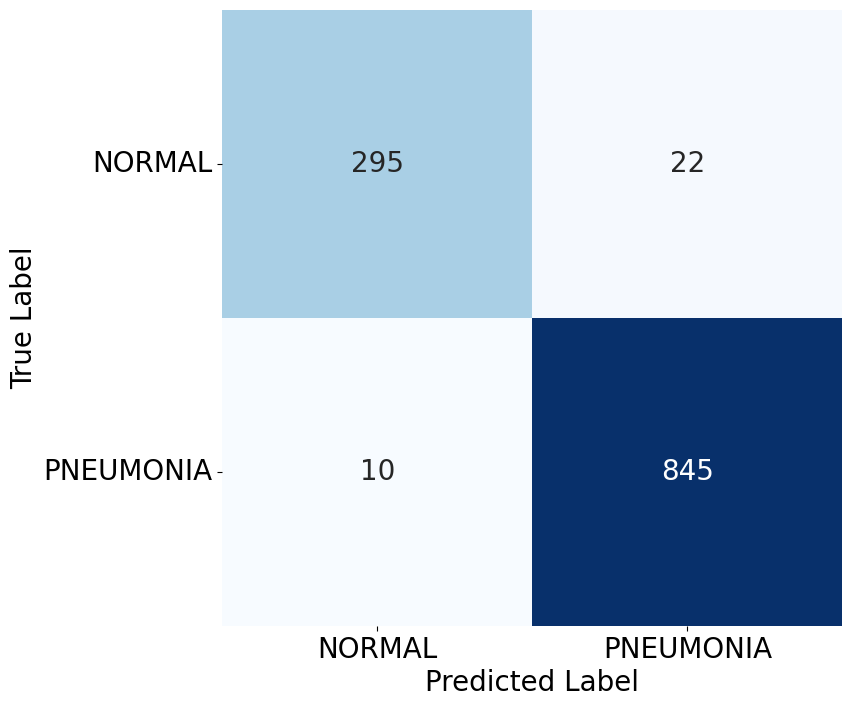

In [23]:
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np


# # Get the confusion matrix
# cm = confusion_matrix(y_true, y_pred)

# # Plot the confusion matrix
# plt.figure(figsize=(8,8))
# sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()

# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the font size
font_size = 20

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, annot_kws={"fontsize": font_size}, cbar=False)
plt.xlabel("Predicted Label", fontsize=font_size)
plt.ylabel("True Label", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size, rotation=0)
plt.show()